In [1]:
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

filePath = "./Speed_Dating_Data.csv" 
df = pd.read_csv(filePath)
df.iid = df.iid.astype(float)
df.pid = df.pid.astype(float)

FIGURE_SIZE = (15, 8)

# Intro
This notebook is an exploration of speed dating data by Shreyas Kadekodi and Saurabh Totey for CSCI 3022 at CU Boulder. We used this data to try and confirm 'common sense' as well try and explore other interesting possible correlations.

## Data Format
All of the data was obtained from https://www.kaggle.com/annavictoria/speed-dating-experiment. In general, the data is in a CSV where each row corresponds to a date. If there is data tied to an individual, it is generally repeated in future rows but there are many omissions from the data set.

## Question: Are matches more common for people with similar attractivenesses?
asdf explain methodology and question and stuff asdf explain what we do below asdf

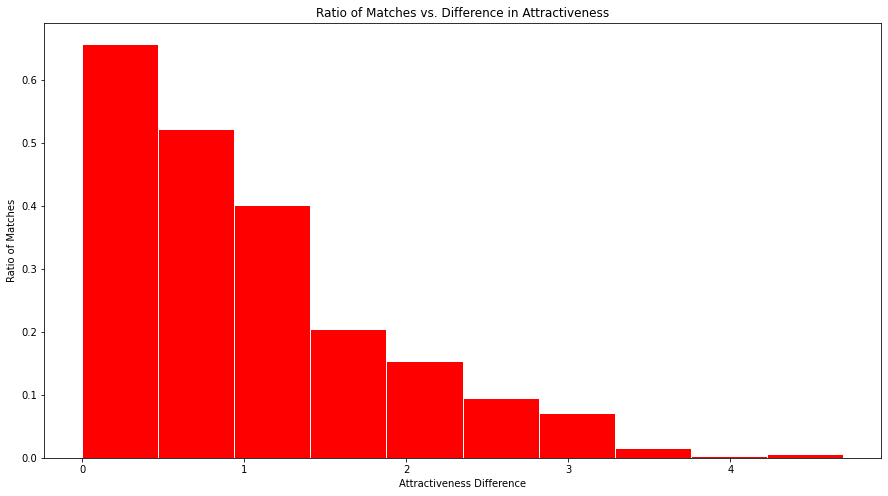

In [2]:
iids = pd.unique(df.iid)

# Assigns every unique person (by their iid) an attractiveness score based on the average of what their partners rated them
personToAttractiveness = {}
for subjectOfInterest in iids:
    attractiveness = statistics.mean(df[(df.iid == subjectOfInterest) & (df.attr_o.notna())].attr_o)
    personToAttractiveness[subjectOfInterest] = attractiveness

# Constructs a dictionary of pairs (tuple of iid and pid) to whether they matched
pairToDidMatch = {}
rowsWithPairs = df[df.iid.notna() & df.pid.notna()]
for iid in iids:
    for pid in rowsWithPairs[rowsWithPairs.iid == iid].pid:
        if (pid, iid) in pairToDidMatch:
            # Asserts that if person A matches with person B, then person B has also matched with person A
            assert rowsWithPairs[(rowsWithPairs.iid == iid) & (rowsWithPairs.pid == pid)].iloc[0].match == pairToDidMatch[(pid, iid)]
            continue
        pairToDidMatch[(iid, pid)] = rowsWithPairs[(rowsWithPairs.iid == iid) & (rowsWithPairs.pid == pid)].iloc[0].match
        
# Gets all the differences of attractivenesses between people of all pairings and also collects whether the pair matched
attractivenessDifferences = [abs(personToAttractiveness[pair[0]] - personToAttractiveness[pair[1]]) for pair in pairToDidMatch.keys()]
correspondingDidMatch = list(pairToDidMatch.values())

# Gets the attractivness difference of people who matched
attractivenessDifferencesOfMatchers = []
for i in range(len(correspondingDidMatch)):
    if correspondingDidMatch[i] == 0:
        continue
    attractivenessDifferencesOfMatchers.append(attractivenessDifferences[i])

# Plots a density histogram of people who matched where the bins are of their attractiveness difference
plt.figure(figsize=FIGURE_SIZE)
plt.hist(attractivenessDifferencesOfMatchers, density=True, color="red", edgecolor="white")
plt.title("Ratio of Matches vs. Difference in Attractiveness")
plt.xlabel("Attractiveness Difference")
plt.ylabel("Ratio of Matches")
plt.show()

### Analysis
TODO: explain the above data/chart

## Question: Do attractive people match more?
asdf explain methodology and question and stuff asdf

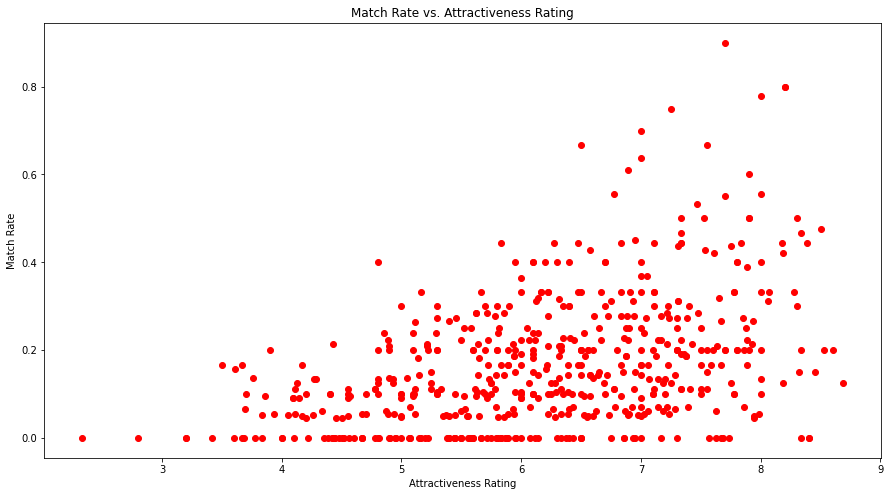

In [3]:
# Gets a list of attractivenesses of all people and calculates the proportion of matches they made
attractivenesses = list(personToAttractiveness.values())
correspondingMatchRate = []
for subjectOfInterest in iids:
    rowsOfPerson = df[(df.iid == subjectOfInterest) & (df.pid.notna())]
    matchSuccessRate = len(rowsOfPerson[rowsOfPerson.match == 1]) / len(rowsOfPerson)
    correspondingMatchRate.append(matchSuccessRate)

# Plots a scatter plot of attractiveness rating and match rate with the corresponding linear regression
plt.figure(figsize=FIGURE_SIZE)
plt.plot(attractivenesses, correspondingMatchRate, "or")
plt.title("Match Rate vs. Attractiveness Rating")
plt.xlabel("Attractiveness Rating")
plt.ylabel("Match Rate")
plt.show()

### Analysis
TODO: explain the above data/chart and then explain why trying binning below.

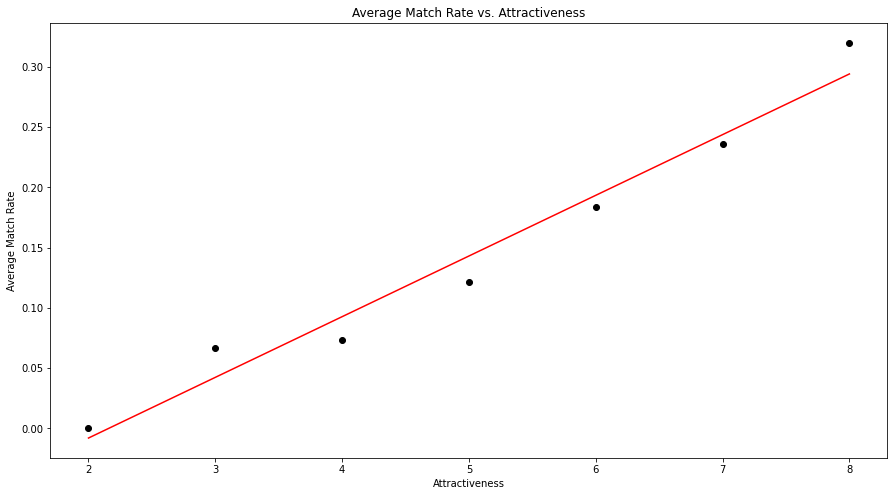

Linear Regression Equation: y =    0.05035x +   -0.10867.


In [4]:
# Maps an attractiveness bin (all atractivenesses that are in the same 'group') to a list of match rates
bins = range(1, 11)
binToMatchRates = {binValue: [] for binValue in bins}
for i in range(len(attractivenesses)):
    attractiveness = attractivenesses[i]
    binValue = int(attractiveness)
    binToMatchRates[binValue].append(correspondingMatchRate[i])
    
# Removes empty values from the dictionary
for binValue in bins:
    if len(binToMatchRates[binValue]) == 0:
        del binToMatchRates[binValue]
        
# Linear regression
x = list(binToMatchRates.keys())
y = [statistics.mean(matchRates) for matchRates in list(binToMatchRates.values())]
linearRegressionCoefficients = np.polyfit(x, y, 1)
lineFunction = np.poly1d(linearRegressionCoefficients)
    
# Plots the average match rate for each attractiveness bin
plt.figure(figsize=FIGURE_SIZE)
plt.plot(x, y, "ok", x, lineFunction(x), "-r")
plt.title("Average Match Rate vs. Attractiveness")
plt.xlabel("Attractiveness")
plt.ylabel("Average Match Rate")
plt.show()

# Prints the linear regression equation
print("Linear Regression Equation: y = {:10.5f}x + {:10.5f}.".format(*linearRegressionCoefficients))

### Analysis
TODO: explain the above data/chart and whether it is different from the first scatter plot.

## Question: Does dating within your field improve your chances of matching?
TODO: explain. Also explain what homogeneous means in this context.

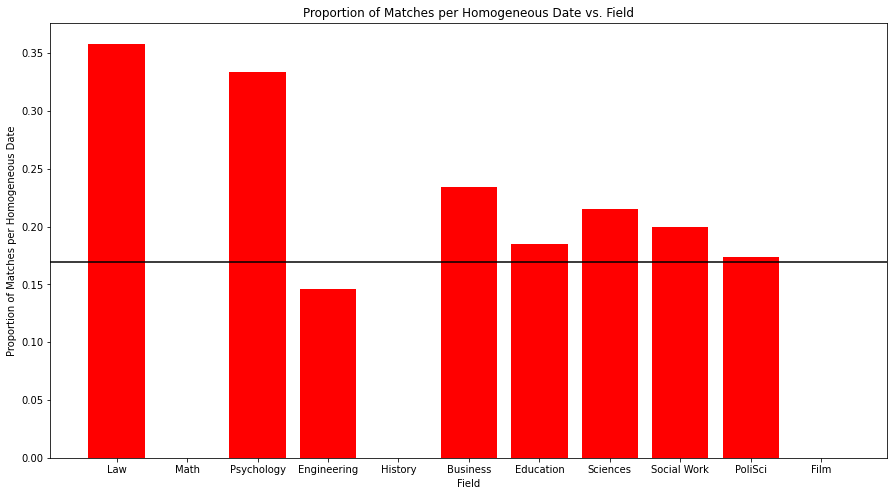

In [5]:
# Creates a mapping of iid to profession
individualToProfession = {iid: None for iid in iids}
for iid in iids:
    relevantRow = df[(df.iid == iid) & (df.field_cd.notna())]
    if len(relevantRow) != 0:
        individualToProfession[iid] = relevantRow.iloc[0].field_cd

# Deletes bad entries from the individualToProfession dictionary
# Ensures that each individual has a valid non-None profession
# Any individual with profession 18 ('other') is filtered out as well because 'other' is not a specific field
for iid in list(individualToProfession.keys()):
    if individualToProfession[iid] == None or individualToProfession[iid] == 18:
        del individualToProfession[iid]
        
# Goes through the pairs and checks whether they had the same profession (and if so, whether they matched)
# Instead of using a dictionary, a list is used because the profession numbers can be considered indices when shifted down by 1
# Homogeneous in this scenario means that both members of the pair have the same profession
professionToNumberOfHomogeneousDates = [0 for _ in range(17)]
professionToNumberOfHomogeneousMatches = [0 for _ in range(17)]
for pair in pairToDidMatch:
    if pair[0] not in individualToProfession or pair[1] not in individualToProfession:
        continue
    if individualToProfession[pair[0]] == individualToProfession[pair[1]]:
        profession = int(individualToProfession[pair[0]] - 1)
        professionToNumberOfHomogeneousMatches[profession] += pairToDidMatch[pair]
        professionToNumberOfHomogeneousDates[profession] += 1

titles = ['Law', 'Math', 'Psychology', 'Medical', 'Engineering', 'English', 'History', 'Business', 'Education', 'Sciences', 'Social Work', 'Undecided', 'PoliSci', 'Film', 'Arts', 'Languages', 'Architecture']

# Maps each profession to the rate at which homogeneous matches were made
# No mappings are made for professions without homogeneous dates
professionToMatchRate = {
    i: professionToNumberOfHomogeneousMatches[i] / professionToNumberOfHomogeneousDates[i]
    for i in range(len(professionToNumberOfHomogeneousDates))
    if professionToNumberOfHomogeneousDates[i] != 0
}

# Plots a bar chart
plt.figure(figsize=FIGURE_SIZE)
plt.bar([titles[i] for i in list(professionToMatchRate.keys())], list(professionToMatchRate.values()), color="red")
plt.axhline(y=statistics.mean(correspondingMatchRate), color="black")
plt.title("Proportion of Matches per Homogeneous Date vs. Field")
plt.xlabel("Field")
plt.ylabel("Proportion of Matches per Homogeneous Date")
plt.show()

### Analysis
TODO: analysis and stuff. explain that black line is the average match rate in general.